## 随机森林：RF
随机森林是一种一决策树为基学习器的Bagging算法，但是不同之处在于RF决策树的训练过程中还加入了随机属性选择（特征上的子采样）
 - 传统的决策树在选择划分的属性时，会选择最优属性
 - RF
  1. 首先，从该节点的属性中损及选择出K个属性组成一个随机子集（类也就是Bagging中的Random Subspaces,一般通常K=log2(n))
  2. 然后再从这个子集中选择一个最右子集进行划分
  
### 参数
使用这些方法时要调整的参数主要是 `n_estimators` 和 `max_features`。 前者（`n_estimators`）是森林里树的数量，通常数量越大，效果越好，但是计算时间也会随之增加。 此外要注意，当树的数量超过一个临界值之后，算法的效果并不会很显著地变好。 后者（`max_features`）是分割节点时考虑的特征的随机子集的大小。 这个值越低，方差减小得越多，但是偏差的增大也越多。 根据经验，回归问题中使用 `max_features = n_features `， 分类问题使用` max_features = sqrt`（n_features （其中 n_features 是特征的个数）是比较好的默认值。` max_depth = None `和 `min_samples_split = 2` 结合通常会有不错的效果（即生成完全的树）。 请记住，这些（默认）值通常不是最佳的，同时还可能消耗大量的内存，最佳参数值应由交叉验证获得。 另外，请注意，在随机森林中，默认使用自助采样法（bootstrap = True）， 然而 extra-trees 的默认策略是使用整个数据集（bootstrap = False）。 当使用自助采样法方法抽样时，泛化精度是可以通过剩余的或者袋外的样本来估算的，设置 `oob_score = True` 即可实现。

提示:

默认参数下模型复杂度是：`O(M*N*log(N))` 
， 其中 M 是树的数目， N 是样本数。 可以通过设置以下参数来降低模型复杂度： `
min_samples_split , min_samples_leaf , max_leaf_nodes`
和 
`max_depth`。

  
## 偏差与方差问题
### 理论部分
 1. 因为相较于一般的决策树,RF中存在了对特征的子采样,增强了模型的随机性,虽然这增加了偏差,但是是同时因为集成效果,降低了方差,因而这通常在整体上会获得一个更好的模型
 2. 除了普通版本的随机森林以外,我们还可以通过使用极限随机树来构建极限随机森林,**极限随机树与普通随机森林的随机树的区别在于,前者在划分属性的时候并非选取最优属性,而是随机选取(sklearn中的实现方式是,对每个属性生成随机阈值,然后在随即阈值中选择最佳阈值),不过极限随机森林默认没有开启自助采样，bootstrap = False**
 3.最终预测结果的生成:在RF的原始论文中,最终预测结果是对所有预测结果的简单投票,但是在我们常用的机器学习库sklearn中,则是取每个分类器预测概率的平均.
 
### 实验部分
**此处我们对sklearn中的[Single estimator versus bagging: bias-variance decomposition](http://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py)示例进行稍微的修改，用来展示极限随机森林与随机森林，普通决策树在同一数据集上的方差-偏差分解**

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
RandomForestRegressor: 0.0193 (error) = 0.0004 (bias^2)  + 0.0090 (var) + 0.0098 (noise)
ExtraTreesClassifier: 0.0166 (error) = 0.0009 (bias^2)  + 0.0057 (var) + 0.0098 (noise)


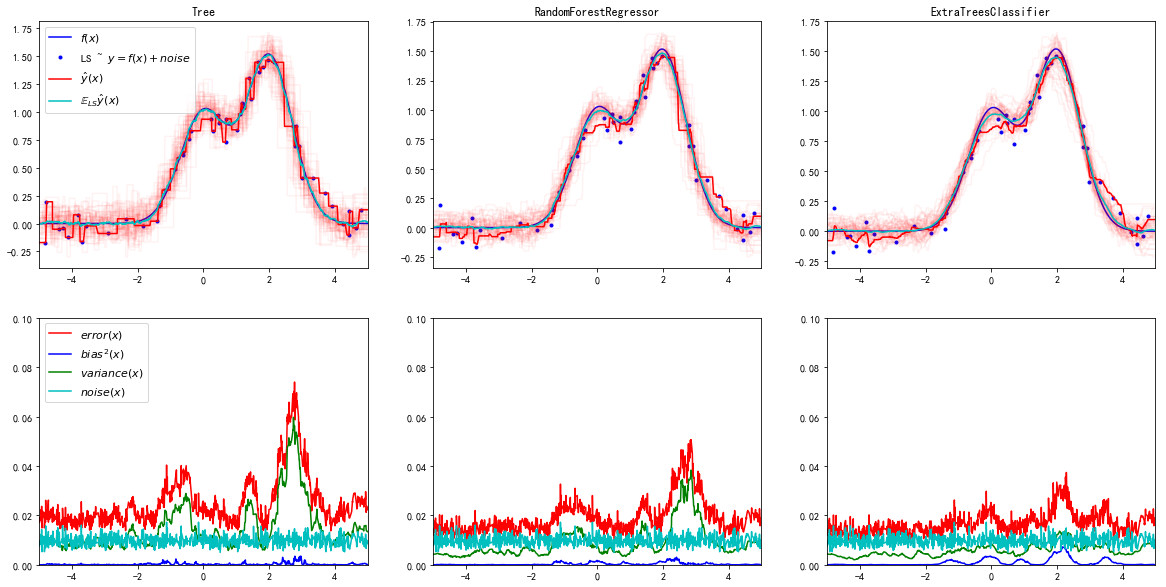

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 10))

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50  # Number of iterations for computing expectations
n_train = 50  # Size of the training set
n_test = 1000  # Size of the test set
noise = 0.1  # Standard deviation of the noise
np.random.seed(0)

estimators = [("Tree", DecisionTreeRegressor()),
              ("RandomForestRegressor", RandomForestRegressor(n_estimators=20,random_state=100,bootstrap = True)),
              ("ExtraTreesClassifier", ExtraTreesRegressor(n_estimators=20,random_state=100,bootstrap = True)), ]

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))
        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label="$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == 0:
        plt.legend(loc="upper left", prop={"size": 11})

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == 0:
        plt.legend(loc="upper left", prop={"size": 11})

plt.show()

In [12]:
# 数据类型变化
print(len(X_train),len(X_train[0]))
print(len(X_test),len(X_test[0]))

print(len(y_train),len(y_train[0]))
print(len(y_test),len(y_test[0]))

print(len(y_predict),len(y_predict[0]))

50 50
1000 1
50 50
1000 50
1000 50


由实验结果我们可以很好地看出,相对于一般的决策树,随机森林虽然增加了模型的偏差,但是大幅度降低了方差,因而在整体上获取了更好的结果;而相比之下,在刚刚实验中的RF算法方差仍然远远大于偏差,这个时候我们就可以采用极限随机森林,正因为一般而言极限随机森林相对于随机森林进一步增加了偏差,同时进一步下降了方差,因为在该实验中极限随机森林应当获取要优于随机森林的效果(不过**这种趋势并不一定是百分之百的**)

## 特征重要程度评估
特征对于目标变量的相对重要程度,可以根据特征使用的相对顺序进行评估。决策树顶部使用的特征对更大一部分输入样本的最终预测结果做出贡献；因此，可以使用接受每个特征对最终预测的贡献的样本比例来评估该 **特征的相对重要性** 。

在RF中，通过岁多个随机数中的预测贡献率进行平均，降低了方差，因此可用于特征选择。**不过要注意的是随机森林与极限随机森林对于同一个数据集根除的重要程度不一定相同,而且即使是一个模型在参数不同的情况下,最终结果也并不一定相同**

因为极限随机森林的特殊性质,所以请不要采用极限随机森林进行特征重要程度的排名,建议使用RF.

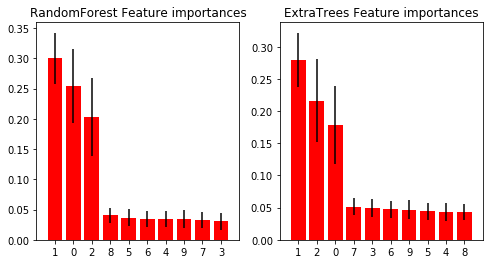

In [10]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

estimators = [("RandomForest", RandomForestClassifier(random_state=100)),
              ("ExtraTrees", ExtraTreesClassifier(random_state=100)), ]

n_estimators = len(estimators)

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)

for n, (name, estimator) in enumerate(estimators):
    estimator.fit(X, y)
    importances = estimator.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
#     print(name +" Feature ranking:")
#     for f in range(X.shape[1]):
#         print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.subplot(1, n_estimators, n + 1)
    plt.title(name + " Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
plt.show()

## 完全随机树嵌入

sklearn中还实现了随机森林的一种特殊用法,即完全随机树嵌入（RandomTreesEmbedding）。RandomTreesEmbedding 实现了一个无监督的数据转换。 通过由完全随机树构成的森林，RandomTreesEmbedding 使用数据最终归属的叶子节点的索引值（编号）对数据进行编码。 该索引以 one-of-K 方式编码，最终形成一个高维的稀疏二进制编码。 这种编码可以被非常高效地计算出来，并且可以作为其他学习任务的基础。 编码的大小和稀疏度可以通过选择树的数量和每棵树的最大深度来确定。对于集成中的每棵树的每个节点包含一个实例（校对者注：这里真的没搞懂）。 编码的大小（维度）最多为 `n_estimators * 2 ** max_depth `，即森林中的叶子节点的最大数。

其作用一共有两种：
 1. 非线性降维
 2. 生成新的特征（此处与GBT系列的效果相似，但是生成的新特征的作用从后面的实验来看，似乎不如GBT系列）
 
 对于功能一
下面是一个验证完全随机树嵌入作用的两个例子：

**例子一：[使用完全随机树嵌入进行散列特征转换](http://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_embedding.html#sphx-glr-auto-examples-ensemble-plot-random-forest-embedding-py)**

RandomTreesEmbedding提供了一种将数据映射到非常高维稀疏表示的方法，这可能有助于分类。该映射是完全无监督的，非常有效。

这个例子显示了由几棵树给出的分区，并且显示了变换如何也可以用于非线性降维或者非线性分类。

相邻的点经常共享同一个树的叶节点并且因此共享大部分的散列表示，这允许截断奇异值分解（truncated SVD）可以分离数据转换后的两个同心圆。

在高维空间中，线性分类器通常达到极好的精度。对于稀疏的二进制数据，`BernoulliNB`特别适合。最下面一行将`BernoulliNB`在变换空间中获得的决策边界与在原始数据上学习的ExtraTreesClassifier森林进行比较。

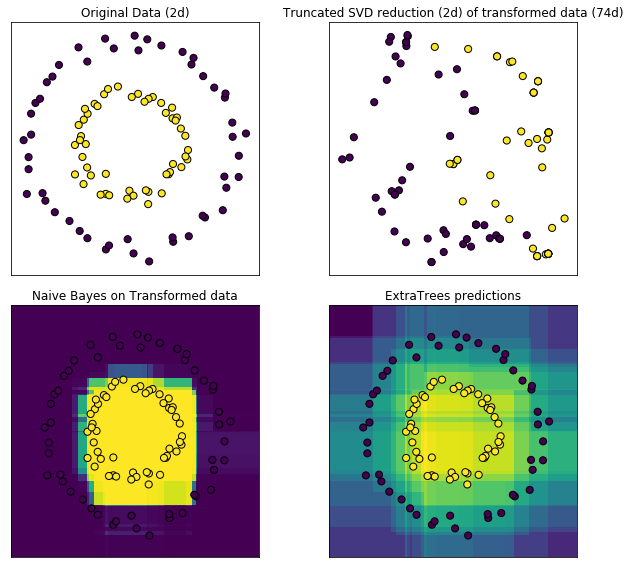

In [7]:
from sklearn.datasets import make_circles
from sklearn.ensemble import RandomTreesEmbedding, ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import BernoulliNB

# make a synthetic dataset
X, y = make_circles(factor=0.5, random_state=0, noise=0.05)

# use RandomTreesEmbedding to transform data
hasher = RandomTreesEmbedding(n_estimators=10, random_state=0, max_depth=3)
X_transformed = hasher.fit_transform(X)

# Visualize result after dimensionality reduction using truncated SVD
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X_transformed)

# Learn a Naive Bayes classifier on the transformed data
nb = BernoulliNB()
nb.fit(X_transformed, y)


# Learn an ExtraTreesClassifier for comparison
trees = ExtraTreesClassifier(max_depth=3, n_estimators=10, random_state=0)
trees.fit(X, y)


# scatter plot of original and reduced data
fig = plt.figure(figsize=(9, 8))

ax = plt.subplot(221)
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k')
ax.set_title("Original Data (2d)")
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(222)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=50, edgecolor='k')
ax.set_title("Truncated SVD reduction (2d) of transformed data (%dd)" %
             X_transformed.shape[1])
ax.set_xticks(())
ax.set_yticks(())

# Plot the decision in original space. For that, we will assign a color
# to each point in the mesh [x_min, x_max]x[y_min, y_max].
h = .01
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# transform grid using RandomTreesEmbedding
transformed_grid = hasher.transform(np.c_[xx.ravel(), yy.ravel()])
y_grid_pred = nb.predict_proba(transformed_grid)[:, 1]

ax = plt.subplot(223)
ax.set_title("Naive Bayes on Transformed data")
ax.pcolormesh(xx, yy, y_grid_pred.reshape(xx.shape))
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k')
ax.set_ylim(-1.4, 1.4)
ax.set_xlim(-1.4, 1.4)
ax.set_xticks(())
ax.set_yticks(())

# transform grid using ExtraTreesClassifier
y_grid_pred = trees.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

ax = plt.subplot(224)
ax.set_title("ExtraTrees predictions")
ax.pcolormesh(xx, yy, y_grid_pred.reshape(xx.shape))
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k')
ax.set_ylim(-1.4, 1.4)
ax.set_xlim(-1.4, 1.4)
ax.set_xticks(())
ax.set_yticks(())

plt.tight_layout()
plt.show()

**[关于生成新特征这一作用的实验](Feature transformations with ensembles of trees)**

完全随机树嵌入,可以将特征转化为更高维度,更稀疏的空间,方式为首先在数据集上训练模型(极限随机森林,随机森林,GBT系列皆可)然后将新的特征空间中每个叶节点都会分配一个固定的特征索引,然后将所有的叶节点进行独热编码,通过将样本所在的叶子设置为1,其他特征设置为0,来对样本进行编码,将其转转换到稀疏的,高维度的空间.

下面的代码展示了,不同转换模型转换出的特征最终得到特征在LR上的分类效果,第二幅图是第一幅图左上角的放大,可以看出在本数据集上似乎还是GBT系列的转换效果好一些(你也可以使用lightGBM与XGBoot中的sklearn借口,实现代码中GradientBoostingClassifier类似的效果)

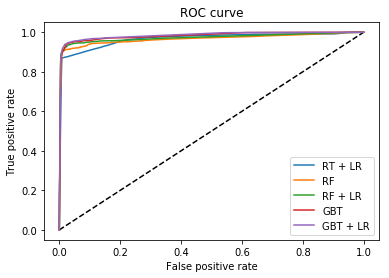

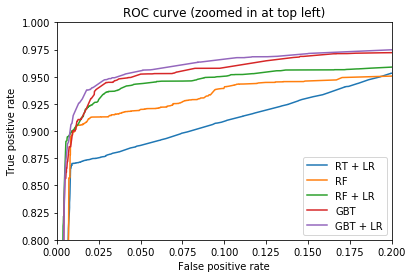

In [9]:
import numpy as np
np.random.seed(10)

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

n_estimator = 10
X, y = make_classification(n_samples=80000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.5)

# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,
	random_state=0)

rt_lm = LogisticRegression()
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression()
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression()
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)


# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)


# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

除此之外,随机森林还可以进行异常检测,sklearn中也实现了该算法[IsolationForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest).更多内容请阅读[我的博客](http://blog.csdn.net/fontthrone)。

## 参考
 - [sklearn官方文档:ensemble](http://scikit-learn.org/stable/modules/ensemble.html)
 - [sklearn官方文档:使用完全随机数进行散列特征转换](http://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_embedding.html#sphx-glr-auto-examples-ensemble-plot-random-forest-embedding-py)
 - [sklearn官方文档:Hashing feature transformation using Totally Random Trees](http://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_embedding.html#sphx-glr-auto-examples-ensemble-plot-random-forest-embedding-py)
 - [sklearn ApacheCN中文官方文档:集成算法](http://sklearn.apachecn.org/cn/0.19.0/modules/ensemble.html)